In [1]:
import numpy as np
from PIL import Image
from matplotlib import transforms, pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

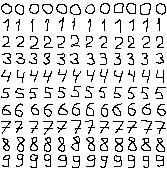

In [2]:
img = Image.open('../data/numbers2.bmp')
img

In [3]:
img = np.array(img).astype(int)

In [4]:
X = np.zeros(shape=(480, 16, 16, 1))
y = np.zeros(shape=480)
example_idx = 0
for i in range(10):
    si, fi = i*17, i*17+16
    for j in range(12):
        sj, fj = j*14, j*14+13
        crop = 1-img[si:fi, sj:fj]
        for k in range(4):
            X[example_idx, 0:16, k:k+13, 0] = crop
            y[example_idx] = i
            example_idx += 1

In [5]:
ohe = OneHotEncoder(categories='auto')
Y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=320, random_state=10)

In [6]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [7]:
# all nets will use the same loss function and optimization step
def build_optimizer_step(learning_rate, y_true, y_hat):
    cross_entropy = y_true*tf.log(y_hat)
    loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return opt

In [8]:
# Let's write a generic training procedure. we will use stochastic 
# gradient descent, providing data for training in batches
def train(session, x_tensor, y_tensor, y_hat_tensor, optimizer_step, n_epochs):
    accuracy = []
    session.run(tf.global_variables_initializer())
    
    for e in range(n_epochs):
        for b in range(X_train.shape[0]):
            session.run(optimizer_step, {x_tensor: X_train[b:b+1], y_tensor: Y_train[b:b+1]})
        y_test_hat = np.argmax(session.run(y_hat_tensor, {x_tensor: X_test}), axis=1)
        accuracy.append(accuracy_score(np.argmax(Y_test, axis=1), y_test_hat))
    return accuracy

In [9]:
session = tf.Session()
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer()

In [10]:
# define placeholders for features and targets
x = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([256, 10], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
y_hat = tf.nn.softmax(a0 + tf.reshape(x, [-1, 256]) @ A)

In [11]:
net1_size = session.run(size)
net1_accuracy = train(session, x, y, y_hat, build_optimizer_step(5e-3, y, y_hat), 100)

In [12]:
# define placeholders for features and targets
x = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

n_hidden = 12

# parameters
A = tf.Variable(initializer([256, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 10], dtype=tf.float64))
b0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# hidden layer
Z = tf.nn.tanh(a0 + tf.reshape(x, [-1, 256])@A)
y_hat = tf.nn.softmax(b0 + Z@B)

In [13]:
net2_size = session.run(size)
net2_accuracy = train(session, x, y, y_hat, build_optimizer_step(5e-3, y, y_hat), 100)

In [14]:
# define placeholders for features and targets
x = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([1, 8, 8, 9], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 8, 8], dtype=tf.float64))
B = tf.Variable(initializer([1, 4, 4, 25], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4], dtype=tf.float64))
C = tf.Variable(initializer([16, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

patches1 = tf.extract_image_patches(
    images=x,
    ksizes=[1, 3, 3, 1],
    strides=[1, 2, 2, 1],
    rates=[1, 1, 1, 1],
    padding='SAME'
)

Z1 = tf.expand_dims(tf.nn.tanh(tf.reduce_sum(patches1 * A, axis=3)+a0), -1)

patches2 = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

Z2 = tf.reshape(
    tf.nn.tanh(tf.reduce_sum(patches2 * B, axis=3)+b0),
    [-1, 16])

y_hat = tf.nn.softmax(c0 + Z2@C)

In [15]:
net3_size = session.run(size)
net3_accuracy = train(session, x, y, y_hat, build_optimizer_step(5e-3, y, y_hat), 100)

In [16]:
x = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([3, 3, 1, 2], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 8, 8, 2], dtype=tf.float64))
B = tf.Variable(initializer([1, 4, 4, 50], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4], dtype=tf.float64))
C = tf.Variable(initializer([16, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

Z1 = tf.nn.tanh(
    tf.nn.conv2d(
        input=x,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

patches = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

Z2 = tf.reshape(tf.nn.tanh(tf.reduce_sum(patches*B, axis=3)+b0), [-1, 16])

y_hat = tf.nn.softmax(c0 + Z2@C)

In [17]:
net4_size = session.run(size)
net4_accuracy = train(session, x, y, y_hat, build_optimizer_step(5e-3, y, y_hat), 100)

In [18]:
x = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([3, 3, 1, 2], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 8, 8, 2], dtype=tf.float64))
B = tf.Variable(initializer([5, 5, 2, 4], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4, 4], dtype=tf.float64))
C = tf.Variable(initializer([64, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

Z1 = tf.nn.tanh(
    tf.nn.conv2d(
        input=x,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

Z2 = tf.reshape(
    tf.nn.tanh(
        tf.nn.conv2d(
            input=Z1,
            filter=B,
            strides=[1, 1, 1, 1],
            padding='VALID') + b0),
    [-1, 64])

y_hat = tf.nn.softmax(c0 + Z2@C)

In [21]:
net5_size = session.run(size)
net5_accuracy = train(session, x, y, y_hat, build_optimizer_step(5e-3, y, y_hat), 100)

In [22]:
#plt.plot(range(50), net4_accuracy)
#plt.plot(range(100), net5_accuracy)
max(net1_accuracy), max(net2_accuracy), max(net3_accuracy), max(net4_accuracy), max(net5_accuracy)

(0.875, 0.875, 0.94375, 0.925, 0.975)

# ZIP Code
Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).

The data is in a numpy compressed file, and each row consists of the digit id (0-9) followed by the 256 grayscale values. The last column contains is_test flag 0 for train and 1 for test observations.

There are 7291 training observations and 2007 test observations.

The test set is notoriously "difficult", and a 2.5% error rate is excellent. These data were kindly made available by the neural network group at AT&T research labs (thanks to Yann Le Cunn).

http://yann.lecun.com/exdb/publis/pdf/lecun-89.pdf

http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf

http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
# PAGE 404. Figure 11.9 shows some examples of normalized handwritten digits,
#           automatically scanned from envelopes by the U.S. Postal Service.
#           The original scanned digits are binary and of different sizes and
#           orientations; the images shown here have been deslanted and size
#           normalized, resulting in 16× 16 grayscale images (Le Cun et al.,
#           1990). These 256 pixel values are used as inputs to the neural
#           network classifier.

# load numpy array from the compressed file
arr = np.load('../data/zip.npy.npz')['arr_0']
# do train-test split by the last column
train, test = arr[arr[:, -1] == 0], arr[arr[:, -1] == 1]
X_train, X_test = train[:, 1:-1], test[:, 1:-1]
y_train, y_test = train[:, 0].astype(int), test[:, 0].astype(int)

# do one hot labels encoding
ohe = OneHotEncoder(categories='auto')
Y_train_one_hot = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
Y_test_one_hot = ohe.fit_transform(y_test.reshape(-1, 1)).toarray()

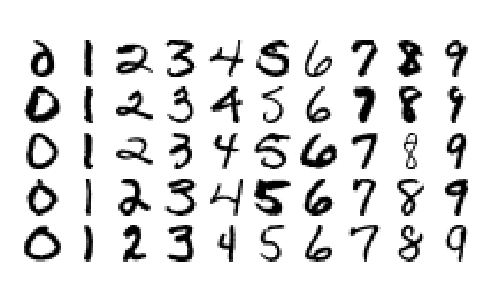

In [15]:
# PAGE 404. FIGURE 11.9. Examples of training cases from ZIP code data. Each
#           image is a 16 × 16 8-bit grayscale representation of a handwritten
#           digit.
w = 20  # pixels for one digit
result = np.ones(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
fig, ax = plt.subplots(figsize=(5.5, 3.3), dpi=110)
ax.imshow(result, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

## Training
The book deliberately uses a subsample of modest size (320 numbers in the training set and 160 numbers in the test set) to emphasize the effects. The exact numbers used are unknown, so I took all the available training and test data. I reproduced the exact architecture of neural networks Net-1 - Net-5 even though it is not a modern approach. As a result, I did not get the effect of overfitting, and there is also no big difference in the classification accuracy. Simple neural networks do not behave as badly as in a book. And Net-5 did not show the same good performance as in the book.

In [4]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [5]:
# all nets will use the same loss function and optimization step
def build_optimizer_step(learning_rate, y_true, y_hat):
    cross_entropy = y_true*tf.log(y_hat)
    loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return opt

In [6]:
# Let's write a generic training procedure. we will use stochastic 
# gradient descent, providing data for training in batches
def train(session, y_hat_tensor, optimizer_step,
          n_epochs, n_batches,
          X_tensor, Y_tensor,
          X_train, Y_train, fd_test):
    accuracy = []
    batches = np.random.randint(0, n_batches, size=X_train.shape[0])
    session.run(tf.global_variables_initializer())
    
    for e in range(n_epochs):
        for b in range(n_batches):
            b_idx = np.where(batches == b)
            fd_train = {X_tensor: X_train[b_idx], Y_tensor: Y_train[b_idx]}
            session.run(optimizer_step, fd_train)
            y_test_hat = np.argmax(session.run(y_hat_tensor, fd_test), axis=1)
        accuracy.append(accuracy_score(y_test, y_test_hat))
    return accuracy

In [7]:
session = tf.Session()
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer()

## Net-1
No hidden layer, equivalent to multinomial logistic regression.

In [8]:
# define placeholders for features and targets
x = tf.placeholder(tf.float64, shape=[None, 256])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([256, 10], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
y_hat = tf.nn.softmax(a0 + x @ A)

In [9]:
net1_size = session.run(size)
net1_accuracy = train(
    session, y_hat, build_optimizer_step(1e-2, y, y_hat),
    30, 100,
    x, y,
    X_train, Y_train_one_hot,
    {x: X_test}
)

## Net-2
One hidden layer, 12 hidden units fully connected.

In [10]:
# define placeholders for features and targets
x = tf.placeholder(tf.float64, shape=[None, 256])
y = tf.placeholder(tf.float64, shape=[None, 10])

n_hidden = 12

# parameters
A = tf.Variable(initializer([256, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 10], dtype=tf.float64))
b0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# hidden layer
Z = tf.nn.sigmoid(a0 + x@A)
y_hat = tf.nn.softmax(b0 + Z@B)

In [12]:
net2_size = session.run(size)
net2_accuracy = train(
    session, y_hat, build_optimizer_step(1e-2, y, y_hat),
    30, 100,
    x, y,
    X_train, Y_train_one_hot,
    {x: X_test}
)

## Net-3
Two hidden layers locally connected.

In [12]:
# define placeholders for features and targets
X = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([1, 8, 8, 9], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 8, 8], dtype=tf.float64))
B = tf.Variable(initializer([1, 4, 4, 25], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4], dtype=tf.float64))
C = tf.Variable(initializer([16, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

patches1 = tf.extract_image_patches(
    images=X,
    ksizes=[1, 3, 3, 1],
    strides=[1, 2, 2, 1],
    rates=[1, 1, 1, 1],
    padding='SAME'
)

Z1 = tf.expand_dims(tf.nn.sigmoid(tf.reduce_sum(patches1 * A, axis=3)+a0), -1)

patches2 = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

Z2 = tf.reshape(
    tf.nn.sigmoid(tf.reduce_sum(patches2 * B, axis=3)+b0),
    [-1, 16])

y_hat = tf.nn.softmax(c0 + Z2@C)

In [13]:
net3_size = session.run(size)
net3_accuracy = train(
    session,
    y_hat,
    build_optimizer_step(1e-2, y, y_hat),
    {X: X_train.reshape((X_train.shape[0], 16, 16, 1)), y: Y_train_one_hot},
    {X: X_test.reshape((X_test.shape[0], 16, 16, 1))}
)

## Net-4
Two hidden layers, locally connected with weight sharing.

In [14]:
X = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([3, 3, 1, 2], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 8, 8, 2], dtype=tf.float64))
B = tf.Variable(initializer([1, 4, 4, 50], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4], dtype=tf.float64))
C = tf.Variable(initializer([16, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

Z1 = tf.nn.sigmoid(
    tf.nn.conv2d(
        input=X,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

patches = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

Z2 = tf.reshape(tf.nn.sigmoid(tf.reduce_sum(patches*B, axis=3)+b0), [-1, 16])

y_hat = tf.nn.softmax(c0 + Z2@C)

In [15]:
net4_size = session.run(size)
net4_accuracy = train(
    session,
    y_hat,
    build_optimizer_step(1.4e-2, y, y_hat),
    {X: X_train.reshape((X_train.shape[0], 16, 16, 1)), y: Y_train_one_hot},
    {X: X_test.reshape((X_test.shape[0], 16, 16, 1))}
)

## Net-5
Two hidden layers, locally connected, two levels of weight sharing.

In [8]:
X = tf.placeholder(tf.float64, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float64, shape=[None, 10])

# parameters
A = tf.Variable(initializer([3, 3, 1, 2], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 8, 8, 2], dtype=tf.float64))
B = tf.Variable(initializer([5, 5, 2, 4], dtype=tf.float64))
b0 = tf.Variable(initializer([1, 4, 4, 4], dtype=tf.float64))
C = tf.Variable(initializer([64, 10], dtype=tf.float64))
c0 = tf.Variable(initializer([10], dtype=tf.float64))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

Z1 = tf.nn.relu(
    tf.nn.conv2d(
        input=X,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

Z2 = tf.reshape(
    tf.nn.relu(
        tf.nn.conv2d(
            input=Z1,
            filter=B,
            strides=[1, 1, 1, 1],
            padding='VALID') + b0),
    [-1, 64])

y_hat = tf.nn.softmax(c0 + Z2@C)

In [9]:
net5_size = session.run(size)
net5_accuracy = train(
    session, y_hat, build_optimizer_step(1e-3, y, y_hat),
    1000, 100,
    X, y,
    X_train.reshape((X_train.shape[0], 16, 16, 1)), Y_train_one_hot,
    {X: X_test.reshape((X_test.shape[0], 16, 16, 1))}
)
#net5_accuracy = train(
#    session, 
#    y_hat,
#    build_optimizer_step(1.4e-2, y, y_hat),
#    {X: X_train.reshape((X_train.shape[0], 16, 16, 1)), y: Y_train_one_hot},
#    {X: X_test.reshape((X_test.shape[0], 16, 16, 1))}
#)

0 0.6522172396611858
1 0.8016940707523668
2 0.8400597907324364
3 0.8550074738415545
4 0.8659691081215745
5 0.8709516691579472
6 0.8804185351270553
7 0.885401096163428
8 0.8898854010961634
9 0.8943697060288989
10 0.8973592426507224
11 0.9023418036870952
12 0.9053313403089188
13 0.9088191330343797
14 0.9098156452416543
15 0.9128051818634778
16 0.9123069257598405
17 0.9138016940707524
18 0.9152964623816642
19 0.9157947184853015
20 0.9157947184853015
21 0.916791230692576
22 0.9157947184853015
23 0.9157947184853015
24 0.9157947184853015
25 0.916791230692576
26 0.9192825112107623
27 0.9202790234180369
28 0.9212755356253114
29 0.9217737917289487
30 0.9217737917289487
31 0.9217737917289487
32 0.9227703039362232
33 0.9237668161434978
34 0.9237668161434978
35 0.9237668161434978
36 0.9227703039362232
37 0.9227703039362232
38 0.9237668161434978
39 0.9232685600398605
40 0.9237668161434978
41 0.9237668161434978
42 0.9237668161434978
43 0.9227703039362232
44 0.922272047832586
45 0.922272047832586
46 

KeyboardInterrupt: 

In [29]:
architectures = [
    'Net-1: Single layer network',
    'Net-2: Two layer network',
    'Net-3: Locally connected',
    'Net-4: Constrained network 1',
    'Net-5: Constrained network 2']
sizes = [net1_size, net2_size, net3_size, net4_size, net5_size]
test_scores = [net1_accuracy, net2_accuracy, net3_accuracy,
               net4_accuracy, net5_accuracy]
best_scores = [max(score) for score in test_scores]

for n, s, b in zip(architectures, sizes, best_scores):
    print(f'{n:<30} {s:>10} {100*b:>10.1f}%')

Net-1: Single layer network          2570       91.6%
Net-2: Two layer network             3214       91.4%
Net-3: Locally connected             1226       91.7%
Net-4: Constrained network 1         1132       91.9%
Net-5: Constrained network 2         1060       92.9%


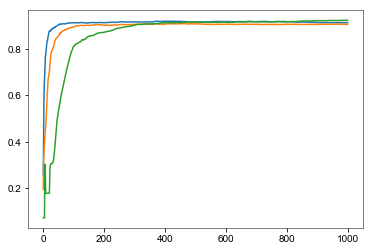

In [13]:
plt.plot(range(1000), net1_accuracy)
plt.plot(range(1000), net2_accuracy)
plt.plot(range(1000), net3_accuracy)